In [282]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

In [283]:
FIG_DIR = "/home/kieran/Level5ProjectAudioVAE/src/evaluation/figures/latent_controller"

In [252]:
sns.set(style='white')

In [253]:
def get_nearest_point(x: float, y: float, df: pd.DataFrame):
    data = np.array([df[f'x_emb_n=0'], df[f'y_emb_n=0']]).T
    point = np.array([x, y])
    dists = np.linalg.norm(data - point, axis=1)
    return np.argmin(dists)

In [254]:
def get_min_max(df: pd.DataFrame, col: str):
    idx_min = df[col].argmin()
    idx_max = df[col].argmax()
    return idx_min, idx_max

In [255]:
def get_start_end(df, start_idx, end_idx):
    x0 = df.iloc[start_idx]['x_emb_n=0']
    y0 = df.iloc[start_idx]['y_emb_n=0']
    
    x1 = df.iloc[end_idx]['x_emb_n=0']
    y1 = df.iloc[end_idx]['y_emb_n=0']
    
    return x0, y0, x1, y1

In [256]:
def get_linear_interpolation(df, start_idx, end_idx):
    x0, y0, x1, y1 = get_start_end(df, start_idx, end_idx)
    
    return np.linspace(start=[x0, y0], stop=[x1, y1], num=100)

In [257]:
def get_param_df_interpolation(df, lin, param_names):
    params = []

    for point in lin:
        idx = get_nearest_point(point[0], point[1], df)
        row = df.iloc[idx]
        row_params = row[param_names]
        params.append(row_params.values)
        
    return pd.DataFrame(np.array(params), columns=param_names)

In [399]:
def plot_column_interpolation(df, df_col, fig_name):
    params = [col for col in df.columns if 'p_hat' in col]
    idx_min, idx_max = get_min_max(df, df_col)
    lin = get_linear_interpolation(df, idx_min, idx_max)
    
    params_df = get_param_df_interpolation(df, lin, params)
    
    red = sns.color_palette(n_colors=4).as_hex()[3]
    fig, ax = plt.subplots(2,1, figsize=(6,8))
    
    sns.scatterplot(df, x='x_emb_n=0', y='y_emb_n=0', ax=ax[0])
    x0, y0, x1, y1 = get_start_end(od_df, idx_min, idx_max)
    ax[0].plot([x0, x1], [y0, y1], color = red)
    plt.show()

    for param in params:
        x = np.linspace(0,1,len(params_df))
        xnew = np.linspace(0, 1, num=len(params_df)*2, endpoint=True)
        y = params_df[param]
        f_cubic = interp1d(x, y, kind='cubic')
        sns.lineplot(x=xnew, y=f_cubic(xnew), ax=ax, label=param.strip('p_hat_'))
        
    
    
    # specifying plot coordinates
    plt.plot((0, 0), (0, 1), scaley = False, linestyle='--', color=red)
    plt.plot((0.5, 0.5), (0, 1), scaley = False, linestyle='--', color=red)
    plt.plot((1, 1), (0, 1), scaley = False, linestyle='--', color=red)

    ax.set_ylabel('Parameter value')
    ax.set_xlabel('Interpolation step')
    ax.set_xticks([0, .5, 1])
    ax.set_xticklabels(['A', 'C', 'B'], color=red)
    ax.set_ylim([0,1])
    
    ax.yaxis.grid(True)
    
    plt.savefig(f"{FIG_DIR}/{fig_name}.pdf")

In [400]:
od_df = pd.read_csv("/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/latent_controller/overdrive.csv")
mb_df = pd.read_csv("/home/kieran/Level5ProjectAudioVAE/src/evaluation/data/latent_controller/multiband.csv")

In [401]:
od_params = [col for col in od_df.columns if 'p_hat' in col]
mb_params = [col for col in mb_df.columns if 'p_hat' in col]

In [402]:
print(od_params)
print(mb_params)

['p_hat_drive', 'p_hat_muffle', 'p_hat_output_db']
['p_hat_l_m_hz', 'p_hat_m_h_hz', 'p_hat_l_comp_db', 'p_hat_m_comp_db', 'p_hat_h_comp_db', 'p_hat_l_out_db', 'p_hat_m_out_db', 'p_hat_h_out_db', 'p_hat_attack_s', 'p_hat_release_ms', 'p_hat_stereo_width']


In [403]:
idx_min, idx_max = get_min_max(od_df, 'x_emb_n=0')

In [404]:
lin = get_linear_interpolation(od_df, idx_min, idx_max)

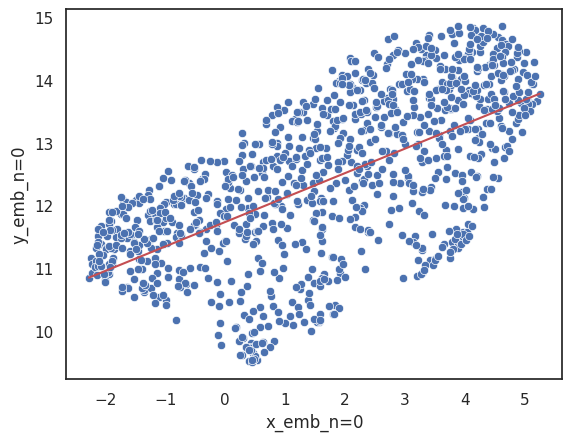

In [407]:
ax = sns.scatterplot(od_df, x='x_emb_n=0', y='y_emb_n=0')
x0, y0, x1, y1 = get_start_end(od_df, idx_min, idx_max)
ax.plot([x0, x1], [y0, y1], color = 'r')
plt.show()

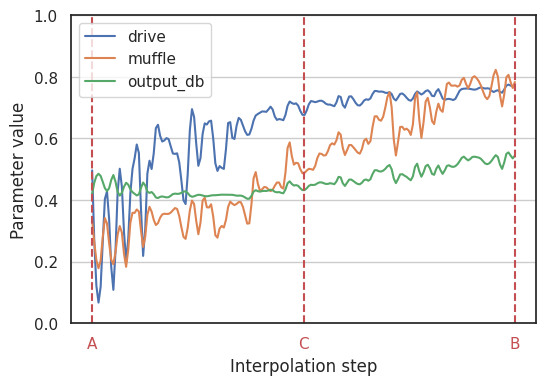

In [406]:
plot_column_interpolation(od_df, 'x_emb_n=0', 'x_interpolation')